In [1]:
# Load libraries
library(tidyverse)
library(lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.1.8
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Read multiple csv files from directory 
path <- '../input/dhakaaqirain/'
years <- 2016:2023
dfs <- map(years, ~read.csv(paste0(path, 'Dhaka_PM2.5_', .x, '_YTD.csv')))

In [3]:
# Combine all csv dataframes to one dataframe appending as new rows
combined_aqi <- bind_rows(dfs)

In [4]:
# Inspect all rows with column name and data type
glimpse(combined_aqi)

Rows: 60,396
Columns: 14
$ Site          <chr> "Dhaka", "Dhaka", "Dhaka", "Dhaka", "Dhaka", "Dhaka", "D…
$ Parameter     <chr> "PM2.5 - Principal", "PM2.5 - Principal", "PM2.5 - Princ…
$ Date..LT.     <chr> "2016-01-01 01:00 AM", "2016-01-01 02:00 AM", "2016-01-0…
$ Year          <int> 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 20…
$ Month         <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ Day           <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ Hour          <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1…
$ NowCast.Conc. <dbl> -999, -999, -999, -999, -999, -999, -999, -999, -999, -9…
$ AQI           <int> -999, -999, -999, -999, -999, -999, -999, -999, -999, -9…
$ AQI.Category  <chr> "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A", …
$ Raw.Conc.     <dbl> -999, -999, -999, -999, -999, -999, -999, -999, -999, -9…
$ Conc..Unit    <chr> "UG/M3", "UG/M3", "UG/M3", "UG/M3", "UG/M3", "UG/M3", "U…
$ Duration     

In [5]:
# Create subset with specific columns and exclude rows with AQI no data where AQI flagged as AQI= -999
dhaka_aqi_16_22_cleaned <- combined_aqi %>%
  filter(AQI != -999) %>%
  dplyr::select('Date..LT.', AQI, 'AQI.Category') %>%
  rename(datetime = `Date..LT.`, aqi = AQI, category = 'AQI.Category')

In [6]:
# Inspect all rows with column name and data type
glimpse(dhaka_aqi_16_22_cleaned)

Rows: 58,527
Columns: 3
$ datetime <chr> "2016-03-01 03:00 AM", "2016-03-01 04:00 AM", "2016-03-01 05:…
$ aqi      <int> 302, 296, 314, 307, 288, 278, 256, 215, 247, 235, 196, 192, 1…
$ category <chr> "Hazardous", "Very Unhealthy", "Hazardous", "Hazardous", "Ver…


In [7]:
# Change datetime column as datatime object by lubridate
dhaka_aqi_16_22_cleaned <- dhaka_aqi_16_22_cleaned %>%
  dplyr::mutate(date_time = lubridate::ymd_hm(datetime)) %>%
  dplyr::select(-1) %>%
  dplyr::arrange(date_time) %>%
  tibble::rownames_to_column(var = "id")

Warning message:
“There was 1 warning in `dplyr::mutate()`.
ℹ In argument: `date_time = lubridate::ymd_hm(datetime)`.
Caused by warning:
!  2160 failed to parse.”


In [8]:
# Inspect all rows with column name and data type
glimpse(dhaka_aqi_16_22_cleaned)

Rows: 58,527
Columns: 4
$ id        <chr> "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12…
$ aqi       <int> 302, 296, 314, 307, 288, 278, 256, 215, 247, 235, 196, 192, …
$ category  <chr> "Hazardous", "Very Unhealthy", "Hazardous", "Hazardous", "Ve…
$ date_time <dttm> 2016-03-01 03:00:00, 2016-03-01 04:00:00, 2016-03-01 05:00:…


In [9]:
# Resample the dataframe using the "D" frequency (for daily frequency)
daily_df <- dhaka_aqi_16_22_cleaned %>%
  dplyr::group_by(date = as.Date(date_time)) %>%
  dplyr::summarise(aqi = round(mean(aqi)),
                   category = ifelse(n() > 0, names(sort(-table(category)))[1], "NA"))

In [10]:
# Inspect all rows with column name and data type
glimpse(daily_df)

Rows: 2,383
Columns: 3
$ date     <date> 2016-03-01, 2016-03-02, 2016-03-03, 2016-03-04, 2016-03-05, …
$ aqi      <dbl> 243, 235, 243, 171, 191, 195, 172, 185, 177, 181, 174, 178, 1…
$ category <chr> "Very Unhealthy", "Unhealthy", "Unhealthy", "Unhealthy", "Unh…


In [11]:
# Select the "date", "aqi", and "category" columns and create a new dataframe
daily_avg_aqi_category_df <- daily_df %>%
  dplyr::select(date, aqi, category) %>%
  dplyr::arrange(date)

In [12]:
# Inspect all rows with column name and data type
glimpse(daily_avg_aqi_category_df)

Rows: 2,383
Columns: 3
$ date     <date> 2016-03-01, 2016-03-02, 2016-03-03, 2016-03-04, 2016-03-05, …
$ aqi      <dbl> 243, 235, 243, 171, 191, 195, 172, 185, 177, 181, 174, 178, 1…
$ category <chr> "Very Unhealthy", "Unhealthy", "Unhealthy", "Unhealthy", "Unh…


In [13]:
# Make AQI category based on AQI value
daily_avg_aqi_category <- daily_avg_aqi_category_df %>%
  mutate(aqi_category = case_when(
    aqi <= 50 ~ "Good",
    aqi <= 100 ~ "Moderate",
    aqi <= 150 ~ "Unhealthy for Sensitive Groups",
    aqi <= 200 ~ "Unhealthy",
    aqi <= 300 ~ "Very Unhealthy",
    TRUE ~ "Hazardous"
  ))

In [14]:
# Inspect all rows with column name and data type
glimpse(daily_avg_aqi_category)

Rows: 2,383
Columns: 4
$ date         <date> 2016-03-01, 2016-03-02, 2016-03-03, 2016-03-04, 2016-03-…
$ aqi          <dbl> 243, 235, 243, 171, 191, 195, 172, 185, 177, 181, 174, 17…
$ category     <chr> "Very Unhealthy", "Unhealthy", "Unhealthy", "Unhealthy", …
$ aqi_category <chr> "Very Unhealthy", "Very Unhealthy", "Very Unhealthy", "Un…


In [15]:
# Read the csv file for rain data into a data frame
rain_data <- read.csv('../input/dhakaaqirain/CCS_20160101_20230401.csv')

In [16]:
# Inspect all rows with column name and data type
glimpse(rain_data)

Rows: 2,648
Columns: 7
$ Time      <chr> "CCS_1d20160101", "CCS_1d20160102", "CCS_1d20160103", "CCS_1…
$ Rain.mm.  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, …
$ Latitude  <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ X23.796   <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ Longitude <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ X90.423   <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …
$ X         <lgl> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, …


In [17]:
# Separate the date column into two columns using the separator "_1d"
rain_data <- tidyr::separate(rain_data, Time, into = c("prefix", "date"), sep = "_1d")

In [18]:
# Remove the prefix column
rain_data <- dplyr::select(rain_data, -prefix)

In [19]:
# # Change date column as date object by lubridate
rain_data_cleaned <- rain_data %>%
  dplyr::mutate(date = lubridate::ymd(date),
                rain = `Rain.mm.`) %>%
  dplyr::select(date, rain) %>%
  dplyr::arrange(date)

In [20]:
# Inspect all rows with column name and data type
glimpse(rain_data_cleaned)

Rows: 2,648
Columns: 2
$ date <date> 2016-01-01, 2016-01-02, 2016-01-03, 2016-01-04, 2016-01-05, 2016…
$ rain <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,…


In [21]:
# Merge AQI and Rain data
merged_aqi_rain <- inner_join(daily_avg_aqi_category, rain_data_cleaned, by = "date")

In [22]:
# Inspect all rows with column name and data type
glimpse(merged_aqi_rain)

Rows: 2,382
Columns: 5
$ date         <date> 2016-03-01, 2016-03-02, 2016-03-03, 2016-03-04, 2016-03-…
$ aqi          <dbl> 243, 235, 243, 171, 191, 195, 172, 185, 177, 181, 174, 17…
$ category     <chr> "Very Unhealthy", "Unhealthy", "Unhealthy", "Unhealthy", …
$ aqi_category <chr> "Very Unhealthy", "Very Unhealthy", "Very Unhealthy", "Un…
$ rain         <dbl> 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, …


In [23]:
# Merge AQI and Rain replace 0 with NA
merged_aqi_rain$rain <- ifelse(merged_aqi_rain$rain == 0, NA, merged_aqi_rain$rain)

In [26]:
# Create a named vector of colors for each AQI Category
aqi_colors <- c("Good" = "#00e400", "Moderate" = "#ffff00", "Unhealthy for Sensitive Groups" = "#ff8000", "Unhealthy" = "#ff0000",
                "Very Unhealthy" = "#8f3f97", "Hazardous" = "#7e0023")

In [27]:
# Create vintagge color palette for making color harmony rule based chart color
color_vintage1 <- c("#F9F5EB", "#E4DCCF", "#EA5455", "#002B5B")
color_vintage2 <- c("#F5E9CF", "#7DB9B6", "#E96479", "#4D455D")
color_vintage3 <- c("#BFDB38", "#FC7300", "#1F8A70", "#00425A")
color_vintage4 <- c("#F2E5E5", "#E8C4C4", "#CE7777", "#2B3A55")
color_vintage5 <- c("#DCD7C9", "#A27B5C", "#3F4E4F", "#2C3639")

In [28]:
# Create Dhaka AQI Rain Viz function
dhaka_aqi_rain_viz <- function(color1, color2, color3, color4) {
  ggplot(data = merged_aqi_rain, aes(x = date, y = aqi, colour = factor(aqi_category, levels = c("Good", "Moderate", "Unhealthy for Sensitive Groups", "Unhealthy", "Very Unhealthy", "Hazardous")))) +
    geom_line(color = "#66947D", size = 0.7) +
    geom_point(size = 2.7, alpha = 0.9) +
    geom_point(aes(y = rain), size = 1.9, color = "#03befc", alpha = 0.6, na.rm = TRUE) +
    scale_color_manual(values = aqi_colors) +
    scale_x_date(date_breaks = "3 month", date_minor_breaks = "1 month", labels = scales::date_format("%b-%y")) +
    scale_y_continuous(name = "Daily Average AQI", sec.axis = sec_axis(~ ., name = "Rain (mm)"), limits = c(0, 400), breaks = c(seq(0, 50, by = 10), seq(50, 400, by = 50))) +
    annotate(geom = "text", x = as.Date("2017-04-01"), y = 390, label = "Higher levels of rainfall are associated with improved air quality", color = "#1F8A70", size = 5.5) +
    annotate(geom = "text", x = as.Date("2023-01-10"), y = 12, label = "Rainfall", color = "#03befc", size = 5) +
    guides(color = guide_legend(override.aes = list(size = 5))) +
    labs(
      title = "Air Quality Index (AQI) of Dhaka",
      subtitle = "As measured since March 2016",
      caption = "Data Analysis & Visualization: Abdul Aziz Pervez, Data Source: AQI:www.airnow.gov, Rain:chrsdata.eng.uci.edu",
      x = "Year",
      y = "Daily Average AQI",
      color = "AQI Category"
    ) +
    theme(plot.title = element_text(vjust = -9, color = color4, size = 25),
          plot.subtitle = element_text(vjust = -12, color = color3, size = 17),
          plot.caption = element_text(color = "gray50", size = 15),
          axis.text.x = element_text(color = "black", size = 12),
          axis.text.y = element_text(color = "black", size = 12),
          axis.title.x = element_text(color = color3, size = 15),
          axis.title.y = element_text(color = color3, size = 15),
          panel.background = element_rect(fill = color1),
          legend.position = "top",
          legend.justification = c(1, -4),
          plot.margin = unit(c(-2.5, 0.5, 0.5, 0.5), "lines"),
          legend.title = element_text(color = color4, size = 11),
          legend.text = element_text(color = color3, size = 10),
          legend.background = element_rect(fill=color1, size=0.5, linetype="solid", 
                                           colour =color1))
}

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


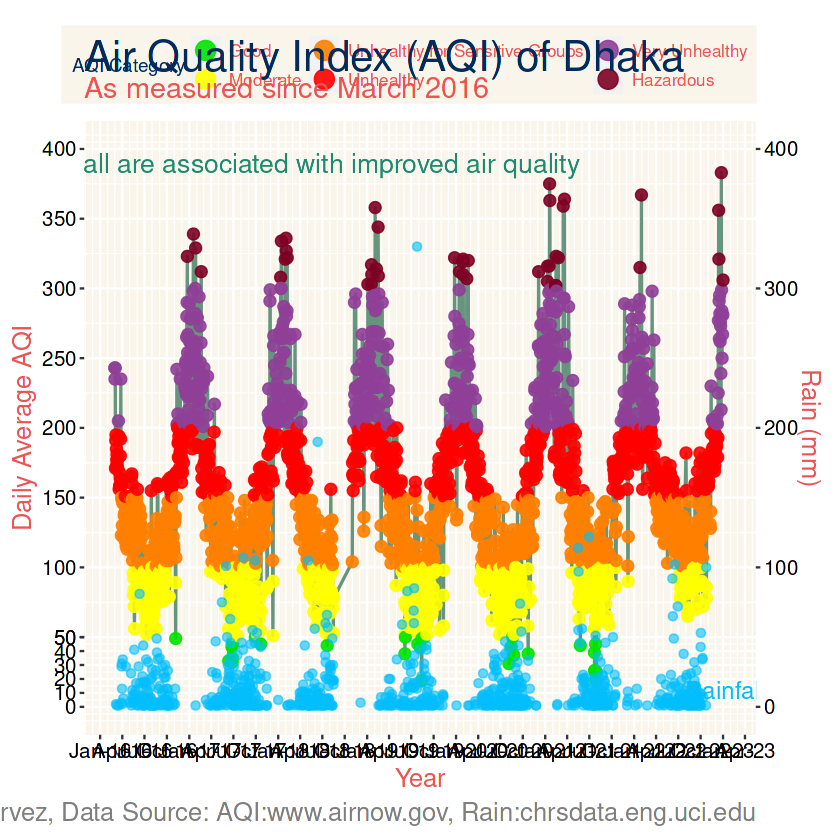

In [29]:
# Invoke function with different color palette
dhaka_aqi_rain_viz(color1=color_vintage1[1], color2=color_vintage1[2], color3=color_vintage1[3], color4=color_vintage1[4])

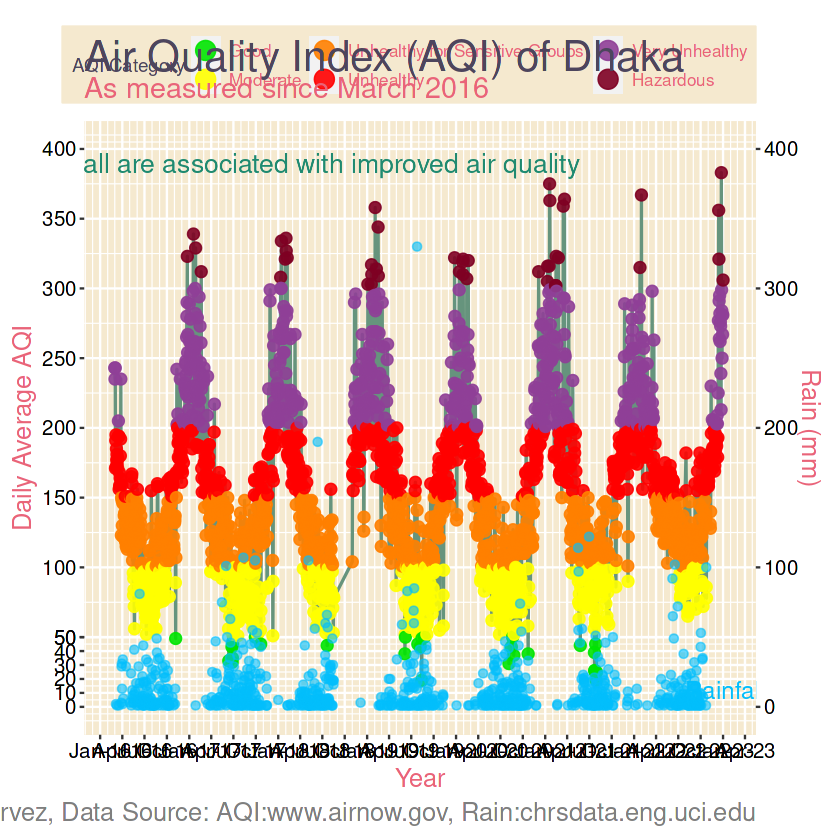

In [30]:
# Invoke function with different color palette
dhaka_aqi_rain_viz(color1=color_vintage2[1], color2=color_vintage2[2], color3=color_vintage2[3], color4=color_vintage2[4])

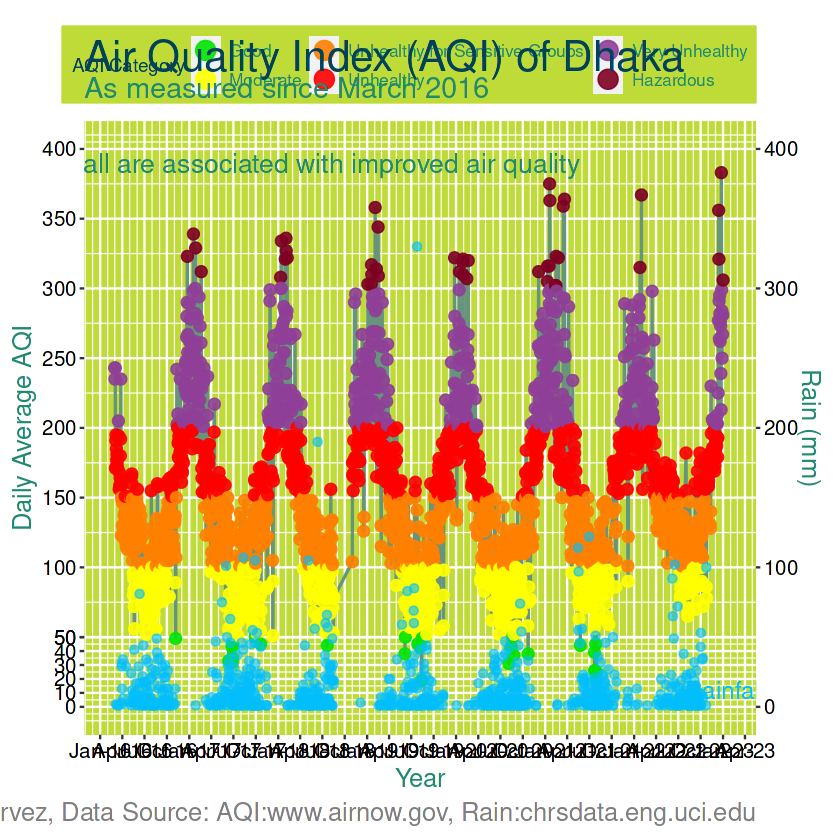

In [31]:
# Invoke function with different color palette
dhaka_aqi_rain_viz(color1=color_vintage3[1], color2=color_vintage3[2], color3=color_vintage3[3], color4=color_vintage3[4])

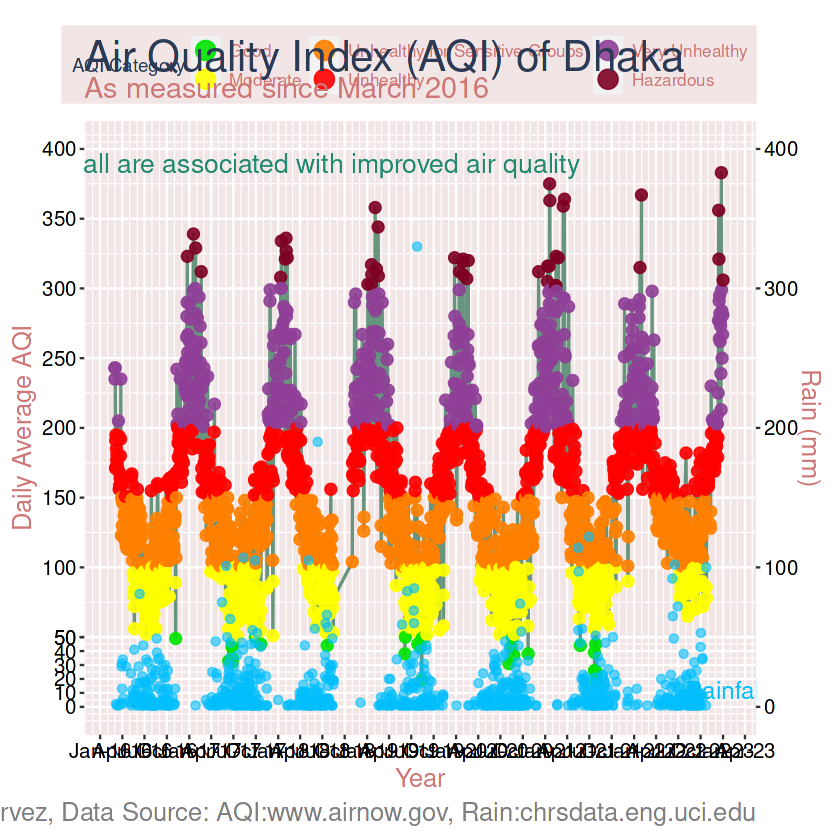

In [32]:
# Invoke function with different color palette
dhaka_aqi_rain_viz(color1=color_vintage4[1], color2=color_vintage4[2], color3=color_vintage4[3], color4=color_vintage4[4])

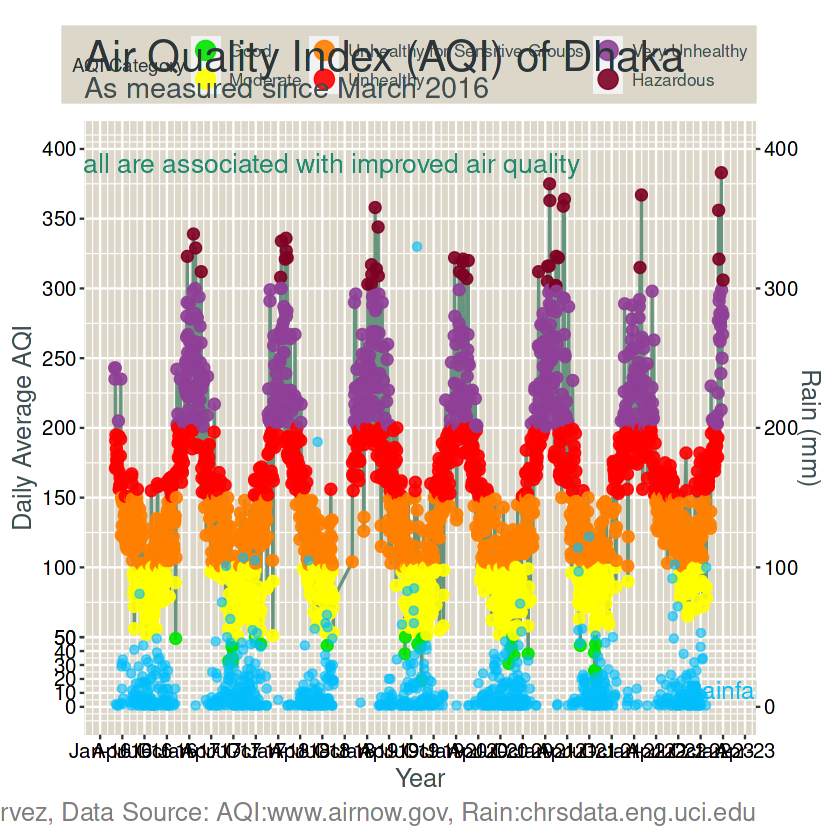

In [33]:
# Invoke function with different color palette
dhaka_aqi_rain_viz(color1=color_vintage5[1], color2=color_vintage5[2], color3=color_vintage5[3], color4=color_vintage5[4])